## Problem set 4
## a)

Non-linear least squares fit with:
\begin{equation*}
d = \frac{p_0}{1+(t-p_1)^2/p_2^2},
\end{equation*}
to the data in 'sidebands.npz'.

Error on fit is: 1584.918936839959


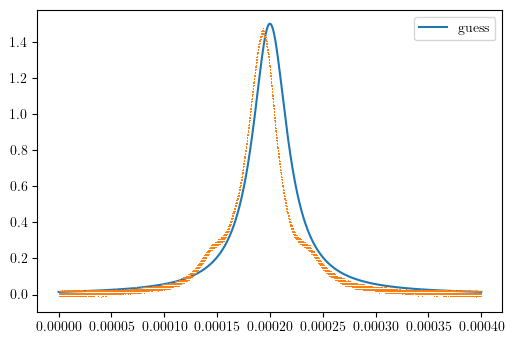


Error on fit is: 1584.918936839959
Error on fit is: 99.7963829092135
Error on fit is: 83.44487317271934
Error on fit is: 83.41545435606989
Error on fit is: 83.40452331592135
Error on fit is: 83.39375969111406
Error on fit is: 83.38300760342312
Error on fit is: 83.37226269635137
Error on fit is: 83.36152466920242
Error on fit is: 83.3507934937863
Best fit parameters are p0= 1.49970971375992 p1= 0.0001923884730818978 p2= 1.6967411973999137e-05


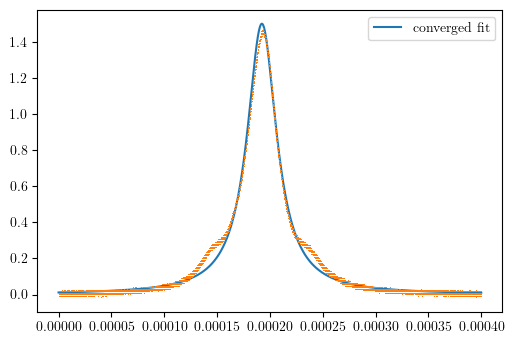

In [6]:
# pset 4
# a)

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 100

data = np.load('sidebands.npz')
t = data['time']
d = data['signal']


# let's try to fit a Lorentzian # f(t) = p0/(1+(t-p1)**2/p2**2)
def lorentz(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))
    # analytic derivative for all parameters
    grad = np.zeros([t.size, p.size])
    grad[:,0]=1/(t+(t-p[1])**2/(p[2]**2))
    grad[:,1]=(2*p[0]*p[2]**2*(t-p[1]))/((t-p[1])**2+p[2]**2)**2
    grad[:,2]=(2*p[0]*p[2]*(t-p[1])**2)/((t-p[1])**2+p[2]**2)**2
    return f, grad

# initial (somewhat good) guess for parameters
p_0 = np.array([1.5,0.0002,0.00002])
d0,grad = lorentz(p_0,t)
r=d-d0
err=(r**2).sum()
print('Error on fit is:',err)
plt.plot(t,d0,label='guess')
plt.plot(t,d,',')
plt.legend()
plt.show()

# Newton's method
p=p_0.copy()
print()
for j in range(10):
    pred,grad=lorentz(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print ('Error on fit is:',err)
print('Best fit parameters are p0=',p[0],'p1=',p[1],'p2=',p[2])  
plt.plot(t,pred,label='converged fit')
plt.plot(t,d,',')
plt.legend()
plt.show()

We see that Newton's method converged pretty fast, and the error on the fit is about 83. This does not look too good, maybe a single Lorentzian isn't a super good fit.

In [2]:
# b)
# let's estimate the noise
N = np.mean((d-pred)**2)
# estimate the error on the parameters
param_err = np.sqrt(N*np.diag(np.linalg.inv(grad.T@grad)))
print('The estimated error on p0 is:', param_err[0])
print('The estimated error on p1 is:', param_err[1])
print('The estimated error on p2 is:', param_err[2])

The estimated error on p0 is: 5.777752590757493e-07
The estimated error on p1 is: 5.658913672030917e-09
The estimated error on p2 is: 5.664769217805371e-09


Error on fit is: 1584.918936839959


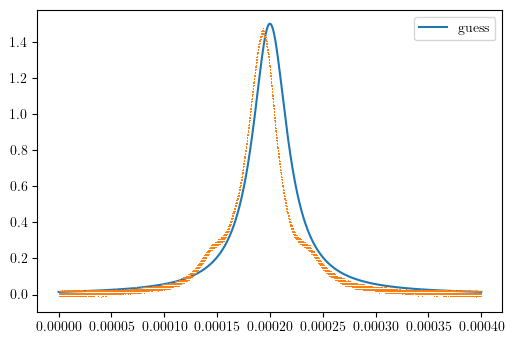


Error on fit is: 1584.918936839959
Error on fit is: 187.52261730459963
Error on fit is: 68.99395926977343
Error on fit is: 63.67344957085435
Error on fit is: 63.67289546155884
Error on fit is: 63.672894140151655
Error on fit is: 63.67289414183747
Error on fit is: 63.672894141855544
Error on fit is: 63.672894141855565
Error on fit is: 63.67289414185555
Best fit parameters are p0= 1.4229939724204521 p1= 0.00019235939144207569 p2= 1.7919065903050577e-05


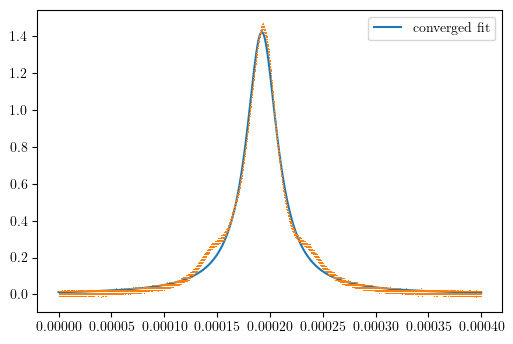

In [5]:
# c)
# using numerical derivatives

# new lorentz function to make it easier to calculate numerical derivatives 
def lorentz2(p0,p1,p2,t):
    f = p0/(1+(t-p1)**2/(p2**2))
    return f

# two points centered derivative w.r.t. all parameters
# there are 3 parameters so i'll do each derivative separately
def derivative(function,dx0,dx1,dx2):
    dp0 = (function(p0+dx0,p1,p2,t) - function(p0-dx0,p1,p2,t))/(2*dx0)
    dp1 = (function(p0,p1+dx1,p2,t) - function(p0,p1-dx1,p2,t))/(2*dx1)
    dp2 = (function(p0,p1,p2+dx2,t) - function(p0,p1,p2-dx2,t))/(2*dx2)
   
    return dp0,dp1,dp2

# third derivative with respect to all parameters for optimal dx estimate
def third_derivative(function,dx):
    d3p0 = (-0.5*function(p0-2*dx,p1,p2,t) + function(p0-dx,p1,p2,t) - function(p0+dx,p1,p2,t) + 0.5*function(p0+2*dx,p1,p2,t))/(dx**3)
    d3p1 = (-0.5*function(p0,p1-2*dx,p2,t) + function(p0,p1-dx,p2,t) - function(p0,p1+dx,p2,t) + 0.5*function(p0,p1+2*dx,p2,t))/(dx**3)
    d3p2 = (-0.5*function(p0,p1,p2-2*dx,t) + function(p0,p1,p2-dx,t) - function(p0,p1,p2+dx,t) + 0.5*function(p0,p1,p2+2*dx,t))/(dx**3)
    return d3p0,d3p1,d3p2

# estimation of optimal dx, from assignment 1
def optimal_dx(function,dx_0):
    third_deriv = third_derivative(function,dx_0)
    
    with np.errstate(divide = 'ignore'):
        dx_1 = np.cbrt((3*function(p0,p1,p2,t)*1e-16)/third_deriv)
    dx_1[np.where(np.isnan(dx_1))] = dx_0
    dx_1[np.where(np.isinf(dx_1))] = dx_0
    
    return np.abs(dx_1)

# numerical derivative using our optimal dx
def numerical_derivative(function):
    # initial guess of dx is 1e-3
    dx = optimal_dx(function, 1e-3)
    # calculating the derivative
    df = derivative(function, dx[0], dx[1], dx[2])
    return df

def lorentz_numerical(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))
    gradn = numerical_derivative(lorentz2)
    grad = np.zeros([t.size,p.size])
    grad[:,0]=gradn[0]
    grad[:,1]=gradn[1]
    grad[:,2]=gradn[2]
    return f, grad

# initial (somewhat good) guess for parameters
p_0 = np.array([1.5,0.0002,0.00002])
p0,p1,p2 = p
d0,grad = lorentz_numerical(p_0,t)
r=d-d0
err=(r**2).sum()
print('Error on fit is:',err)
plt.plot(t,d0,label='guess')
plt.plot(t,d,',')
plt.legend()
plt.show()

# Newton's method
p=p_0.copy()
print()
for j in range(10):
    pred,grad=lorentz_numerical(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print ('Error on fit is:',err)
print('Best fit parameters are p0=',p[0],'p1=',p[1],'p2=',p[2])  
plt.plot(t,pred,label='converged fit')
plt.plot(t,d,',')
plt.legend()
plt.show()

Somehow, it seems like the fit is slightly better using numerical derivatives: error on fit is 63 instead of 83. I did not do anything fancy for the numerical derivatives (I used the 2 point centered derivative with an arbitrary dx of 1e-12) so they might not be super accurate. Old fit parameters are p0= 1.49970971375992 p1= 0.0001923884730818978 p2= 1.6967411973999137e-05.

New fit parameters are p0= 1.4228106917872967 p1= 0.00019235864935885613 p2= 1.7923690668367036e-05.

Looks pretty similar, the difference comes from the fact that the numerical derivatives are not incredibly accurate, I don't believe the answers are statistically different. However, I don't really understand why the fit is "better" with the numerical derivatives.


## d)
Now fit with the sum of three lorentzians:
\begin{equation*}
d = \frac{p_0}{1+(t-p_1)^2/p_2^2} + \frac{p_3}{1+(t-p_4)^2/p_2^2}+ \frac{p_5}{1+(t-p_4)^2/p_2^2},
\end{equation*}
using numerical derivatives again.

Error on fit is: 150.8028544542946


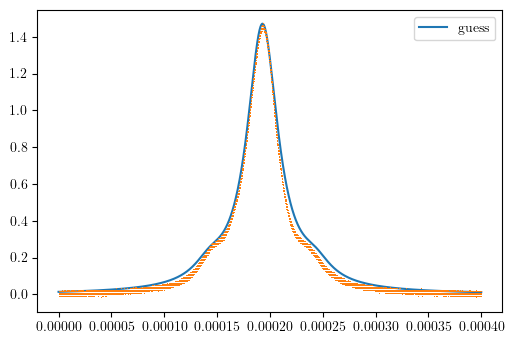


Error on fit is: 150.8028544542946
Error on fit is: 22.130759447836503
Error on fit is: 22.45077232723843
Error on fit is: 22.50703387979615
Error on fit is: 22.373749114213464
Error on fit is: 22.275056288838023
Error on fit is: 22.265059346332198
Error on fit is: 22.28577427993245
Error on fit is: 22.29718017395299
Error on fit is: 22.296772811303654
Best fit parameters are p0= 1.448405770251761 p1= 0.00019253944849952743 p2= 1.577369600371088e-05 p3= 0.1113868608112245 p4= 4.274996719719248e-05 p5= 0.0746152022811609


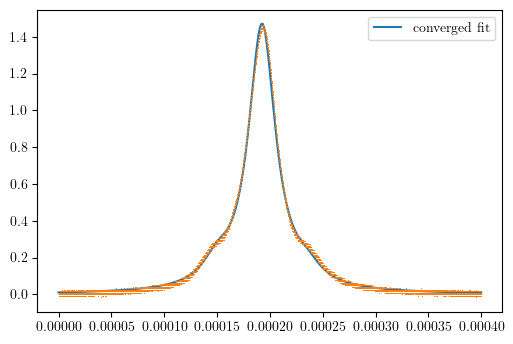

In [7]:
# d)

# sum of 3 lorentzians
def lorentz_sum(p0,p1,p2,p3,p4,p5,t):
    f = p0/(1+(t-p1)**2/(p2**2))+p3/(1+(t-p1+p4)**2/(p2**2))+p5/(1+(t-p1-p4)**2/(p2**2))
    return f

# for the derivatives, same thing as c) but we now have 6 parameters!!
# two points centered derivative w.r.t. all parameters
def derivative(function,dx0,dx1,dx2,dx3,dx4,dx5):
    dp0 = (function(p0+dx0,p1,p2,p3,p4,p5,t) - function(p0-dx0,p1,p2,p3,p4,p5,t))/(2*dx0)
    dp1 = (function(p0,p1+dx1,p2,p3,p4,p5,t) - function(p0,p1-dx1,p2,p3,p4,p5,t))/(2*dx1)
    dp2 = (function(p0,p1,p2+dx2,p3,p4,p5,t) - function(p0,p1,p2-dx2,p3,p4,p5,t))/(2*dx2)
    dp3 = (function(p0,p1,p2,p3+dx3,p4,p5,t) - function(p0,p1,p2,p3-dx3,p4,p5,t))/(2*dx3)
    dp4 = (function(p0,p1,p2,p3,p4+dx4,p5,t) - function(p0,p1,p2,p3,p4-dx4,p5,t))/(2*dx4)
    dp5 = (function(p0,p1,p2,p3,p4,p5+dx5,t) - function(p0,p1,p2,p3,p4,p5-dx5,t))/(2*dx5)
    return dp0,dp1,dp2,dp3,dp4,dp5

# third derivative with respect to all parameters for optimal dx estimate
def third_derivative(function,dx):
    d3p0 = (-0.5*function(p0-2*dx,p1,p2,p3,p4,p5,t) + function(p0-dx,p1,p2,p3,p4,p5,t) - function(p0+dx,p1,p2,p3,p4,p5,t) + 0.5*function(p0+2*dx,p1,p2,p3,p4,p5,t))/(dx**3)
    d3p1 = (-0.5*function(p0,p1-2*dx,p2,p3,p4,p5,t) + function(p0,p1-dx,p2,p3,p4,p5,t) - function(p0,p1+dx,p2,p3,p4,p5,t) + 0.5*function(p0,p1+2*dx,p2,p3,p4,p5,t))/(dx**3)
    d3p2 = (-0.5*function(p0,p1,p2-2*dx,p3,p4,p5,t) + function(p0,p1,p2-dx,p3,p4,p5,t) - function(p0,p1,p2+dx,p3,p4,p5,t) + 0.5*function(p0,p1,p2+2*dx,p3,p4,p5,t))/(dx**3)
    d3p3 = (-0.5*function(p0,p1,p2,p3-2*dx,p4,p5,t) + function(p0,p1,p2,p3-dx,p4,p5,t) - function(p0,p1,p2,p3+dx,p4,p5,t) + 0.5*function(p0,p1,p2,p3+2*dx,p4,p5,t))/(dx**3)
    d3p4 = (-0.5*function(p0,p1,p2,p3,p4-2*dx,p5,t) + function(p0,p1,p2,p3,p4-dx,p5,t) - function(p0,p1,p2,p3,p4+dx,p5,t) + 0.5*function(p0,p1,p2,p3,p4+2*dx,p5,t))/(dx**3)
    d3p5 = (-0.5*function(p0,p1,p2,p3,p4,p5-2*dx,t) + function(p0,p1,p2,p3,p4,p5-dx,t) - function(p0,p1,p2,p3,p4,p5+dx,t) + 0.5*function(p0,p1,p2,p3,p4,p5+2*dx,t))/(dx**3)
    return d3p0,d3p1,d3p2,d3p3,d3p4,d3p5

# estimation of optimal dx, from assignment 1
def optimal_dx(function,dx_0):
    third_deriv = third_derivative(function,dx_0)
    
    with np.errstate(divide = 'ignore'):
        dx_1 = np.cbrt((3*function(p0,p1,p2,p3,p4,p5,t)*1e-16)/third_derivative(function,dx_0))
    dx_1[np.where(np.isnan(dx_1))] = dx_0
    dx_1[np.where(np.isinf(dx_1))] = dx_0
    
    return np.abs(dx_1)

# numerical derivative using our optimal dx
def numerical_derivative(function):
    # initial guess of dx is 1e-3
    dx = optimal_dx(function, 1e-3)
    # calculating the derivative
    df = derivative(function,dx[0],dx[1],dx[2],dx[3],dx[4],dx[5])
    return df

def lorentz_numerical(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))+p[3]/(1+(t-p[1]+p[4])**2/(p[2]**2))+p[5]/(1+(t-p[1]-p[4])**2/(p[2]**2))
    gradn = numerical_derivative(lorentz_sum)
    grad = np.zeros([t.size,p.size])
    grad[:,0]=gradn[0]
    grad[:,1]=gradn[1]
    grad[:,2]=gradn[2]
    grad[:,3]=gradn[3]
    grad[:,4]=gradn[4]
    grad[:,5]=gradn[5]
    return f, grad

# initial (somewhat good) guess for parameters
p_0 = np.array([1.45,0.000193,0.000018,0.09,0.00005,0.09])
p0,p1,p2,p3,p4,p5 = p_0
d0,grad = lorentz_numerical(p_0,t)
r=d-d0
err=(r**2).sum()
print('Error on fit is:',err)
plt.plot(t,d0,label='guess')
plt.plot(t,d,',')
plt.legend()
plt.show()

# Newton's method
p=p_0.copy()
print()
for j in range(10):
    pred,grad=lorentz_numerical(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print ('Error on fit is:',err)
print('Best fit parameters are p0=',p[0],'p1=',p[1],'p2=',p[2],'p3=',p[3],'p4=',p[4],'p5=',p[5])  
plt.plot(t,pred,label='converged fit')
plt.plot(t,d,',')
plt.legend()
plt.show()